In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from scenario import *
#np.random.seed(1234)

import random
import matplotlib
from matplotlib import animation
import matplotlib.patches as mpatch
from matplotlib.animation import FuncAnimation
from itertools import count
from datetime import datetime


Scenario Class

In [2]:
class Scenario: 
    '''
    This class contains the simulation Scenario
    '''

    def __init__(self,demand_duration=3,table_arrangement = [25,18,10,17]):

        self.prob_leave_q = {
            0: 0,
            1: 0.1,
            2:0.3,
            3:0.4,
            4:0.5
        }

        self.table_arrangement = {
            2:table_arrangement[0],
            3:table_arrangement[1],
            4:table_arrangement[2],
            5:table_arrangement[3]
        }

        self.arriving_rate = np.array([
                                        [1,8,3],
                                        [2,14,20],
                                        [3,11,15],
                                        [4,9,13],
                                        [4,7,14]])
        self.demand_duration = demand_duration

Customers Class

In [3]:
class Customers:
    def __init__(self,ID,size,time):
        self.customer_id = ID
        self.group_size = size
        self.time_arrival = time
        
        self.departure_time = 0
        self.seated_time = np.inf
        
        self.in_q = False 
        self.waiting_time = 0
        self.shared = False
        self.revenue = 0
        self.table = np.nan
        self.left = False

    def Seated(self,time,table,shared = False):
        self.seated_time = time
        self.shared = shared
        self.in_q = False
        self.table = table
        
    def Queueing(self,time):
        self.waiting_time += (time-self.time_arrival) 
        self.in_q = True
    
    def Left(self):
        self.seated_time  = 0
        self.in_q = False
        self.left = True
    
    def Departure(self,time):
        draw_time = np.min(((40+exponential_rng(lam = 1/20))/60,2))
        
        if(self.shared == True):
            draw_time = draw_time*0.5

        self.departure_time = self.seated_time + draw_time
        
    def Departure_updated(self,time):
        self.shared = True
        #compute remain time 
        remain_time = (self.departure_time-time)
        self.departure_time =  time + remain_time*0.5 
    
    def Revenue(self):
        amount = (np.random.uniform(0.5,1.2,self.group_size)*60*(self.departure_time-self.seated_time)).sum()
        if(self.shared == True):
            amount = 0.8*amount
            
        self.revenue = amount 

Tables Class

In [4]:
class Tables:
    def __init__(self,ID,size):
        self.table_id = ID
        self.table_size = size
        
        self.busy_seats = 0
        self.available_seats = size
        self.assigned_customer = []
        self.shared = False

    def Assigned_customer(self,customer_ID,group_size):
        customer_assigned = self.assigned_customer
        customer_assigned.extend([customer_ID])
        
        self.assigned_customer = customer_assigned
        if(len(self.assigned_customer)>1):
            self.shared = True
        
        new_busy_seats = self.busy_seats + group_size
        if(new_busy_seats>self.table_size):
            print('Total assigned group exceeds table occupancy')
        
        new_available_seats = self.available_seats-group_size
        
        self.busy_seats = new_busy_seats
        self.available_seats = new_available_seats
        
    def Removed_customer(self,customer_ID, group_size):
        new_assigned_customer = self.assigned_customer
        index = new_assigned_customer.index(customer_ID)
        new_assigned_customer.pop(index)
        
        if(len(new_assigned_customer) == 1):
            self.shared = False
            
        self.assigned_customer = new_assigned_customer
        self.busy_seats = self.busy_seats - group_size
        self.available_seats = self.available_seats + group_size

In [5]:
class Event:
    def __init__(self,time):
        self.time=time
        
class Arrival(Event):
    def __init__(self,time,customer_ID):
        super().__init__(time)
        self.id=customer_ID
        
class Abandon(Event):
    def __init__(self,time,customer_ID):
        super().__init__(time)
        self.id=customer_ID
    
class Departure(Event):
    def __init__(self,time,customer_ID):
        super().__init__(time)
        self.id=customer_ID
    
class Termination(Event):
    def __init__(self,time):
        super().__init__(time)

In [6]:
def exponential_rng(lam=1.0):
    """ Generates exponential random numbers.
    
    Keywords:
        lam (float): the rate parameter, the inverse expectation of the distribution.
    
    Returns:
        exponential random numbers with rate lam
    """
    return -(1/lam)*np.log(np.random.rand())

Customer_arrival

In [7]:
def customer_arrival(t,arriving_rate):
    non_hom_rate = 0
    while non_hom_rate == 0:
        rate = arriving_rate[:,int(np.floor(t))].sum()
        arrival_time = t + exponential_rng(rate) 
        if(np.floor(arrival_time) == np.floor(t)):
            non_hom_rate = 1
        else:
            t = np.floor(t)+1
            if(t == 3):
                arrival_time=np.inf
                group_size=0
                non_hom_rate = 1
                return arrival_time,group_size
    
    draw = np.random.rand()
    non_hom_rate=0
    index=0
    while non_hom_rate==0:
        if draw < arriving_rate[:index,int(np.floor(t))].sum()/rate:
            non_hom_rate = 1
            group_size = index 
        index += 1
    return arrival_time,group_size

Customer_abondan

In [8]:
def customer_abondan(scenario,time,customers,customer_index):
    p = np.random.uniform()
    
    time_interval = time - customers[customer_index].time_arrival
    
    if(time_interval< 5/60):
        prob_leaving = scenario.prob_leave_q[1]
    elif(time_interval< 10/60):
        prob_leaving = scenario.prob_leave_q[2]
    elif(time_interval< 20/60):
        prob_leaving = scenario.prob_leave_q[3]
    else:
        prob_leaving = scenario.prob_leave_q[4]
        
    if(p<prob_leaving):
        new_event_time = -1 
    else:
        new_event_time = time + 5/60
        
    return new_event_time

Seating_strategy_allocation Function

In [9]:
def seating_strategy_allocation(scenario,time,tables,customers,customer_index,q,events):
    '''
    Scenario:
    
    1) Empty table to fit group
    2) No empty tables but enough seats in other tables 
    3) No seats to fit group
    
    Action:
    
    1) Assign customer to empty table (try to match group size to table size)
    2) Assign group to a shared table (minimize empty seat in shared table)
    3) Assign group to q 
    '''
    
    group = customers[customer_index]
    group_size = group.group_size
    
    #Scenratio 1, 2 ,3 
    empty_tables = [x for x in tables if ((x.busy_seats == 0) and ((x.available_seats - group_size) >= 0))] 
    shared_tables = [x for x in tables if ((x.available_seats - group_size) >= 0)] 
    
    if(empty_tables):
        #match table size to group size or assigned to the best option
        empty_tables.sort(key = lambda x:x.available_seats - group_size ,reverse=False) 
        tables[empty_tables[0].table_id].Assigned_customer(customer_index,group_size)
        if(customers[customer_index].in_q == True):
            q-=1
        customers[customer_index].Seated(time,empty_tables[0].table_id)
        customers[customer_index].Departure(time)
        departure = Departure(customers[customer_index].departure_time,customer_index)
        events.append(departure)
        
        #remove previous abondon event
        for event_n in range(len(events)):
            if(isinstance(events[event_n],Abandon)):
                if(events[event_n].id == customer_index):
                    events.pop(event_n)
                    break
        
        
    elif(shared_tables):
        #minimize the number of empty seats in shared table
        shared_tables.sort(key = lambda x:x.available_seats - group_size ,reverse=False)
        tables[shared_tables[0].table_id].Assigned_customer(customer_index,group_size)
        
        if(customers[customer_index].in_q == True):
            q-=1
            
        customers[customer_index].Seated(time,shared_tables[0].table_id,True)
        customers[customer_index].Departure(time)
        departure = Departure(customers[customer_index].departure_time,customer_index)
        events.append(departure)
        
        #remove previous abondon event
        for event_n in range(len(events)):
            if(isinstance(events[event_n],Abandon)):
                if(events[event_n].id == customer_index):
                    events.pop(event_n)
                    break
        

        for c_id in tables[shared_tables[0].table_id].assigned_customer:
            if(c_id != customer_index):
                if(customers[c_id].shared == False):
                    
                    #remove previous departure event
                    for event_n in range(len(events)):
                        if(isinstance(events[event_n],Departure)):
                            if(events[event_n].id == c_id):
                                events.pop(event_n)
                                break
                    customers[c_id].Departure_updated(time)
                    departure = Departure(customers[c_id].departure_time,c_id)
                    events.append(departure)
                    
    elif(customers[customer_index].in_q == False):
        ##Before check if he want's to leavee!!!!
        new_abandon = customer_abondan(scenario,time,customers,customer_index)
        if(new_abandon != -1):
            if(customers[customer_index].waiting_time == 0):
                q += 1

            customers[customer_index].Queueing(new_abandon)
            abandon = Abandon(new_abandon,customer_index)
            events.append(abandon)
        else:
            customers[customer_index].Left()

    return tables , customers , q , events 

Simulate Function

In [10]:
def simulate(scenario,tables, u):    
    ID = 0
    queue=0
    times=[0]
    queues=[0]

    time, group_size = customer_arrival(0,scenario.arriving_rate)

    generation=Arrival(time,ID)
    termination=Termination(scenario.demand_duration)
    events=[generation,termination]

    customers = []
    customer = Customers(ID,group_size,time) 
    customers.append(customer)
    while len(events):
        e=events[0]
        if isinstance(e,Arrival):
            times.append(e.time)
            tables,customers,queue,events = seating_strategy_allocation(scenario,e.time,tables,customers,e.id,queue,events)
            queues.append(queue)
            #next arrival
            time, group_size = customer_arrival(e.time,scenario.arriving_rate)
            if(time<scenario.demand_duration):
                ID += 1
                generation=Arrival(time,ID)
                events.append(generation)
                customer = Customers(ID,group_size,time) 
                customers.append(customer)

        elif isinstance(e,Abandon):
            times.append(e.time)
            new_abandon = customer_abondan(scenario,e.time,customers,e.id)
            if(new_abandon != -1):
                abandon = Abandon(new_abandon,e.id)
                events.append(abandon)
            else:
                queue -=1
                customers[e.id].Left()
            queues.append(queue)

        elif isinstance(e,Departure):
            times.append(e.time)
            #Todo compute revenue and remove customer from table
            customers[e.id].Revenue()
            tables[customers[e.id].table].Removed_customer(e.id,customers[e.id].group_size)


            queing_customer = [x for x in customers if (x.in_q == True)]
            queing_customer.sort(key = lambda x:x.time_arrival,reverse=False) 
            for j in range(len(queing_customer)):
                tables,customers,queue,events = seating_strategy_allocation(scenario,e.time,tables,customers,queing_customer[j].customer_id,queue,events)

            queues.append(queue)

        elif isinstance(e,Termination):
            pass
            print(f'Restaurant closed')

        events.pop(0)
        events.sort(key=lambda event:event.time)
    return times, queues , tables, customers

Run

In [11]:
scenario = Scenario()
tables = []
ID = 0
for table_size in scenario.table_arrangement:
    for i in range(scenario.table_arrangement[table_size]):
        table = Tables(ID,table_size) 
        tables.append(table)
        ID += 1
        

times, queues , tables, customers= simulate(scenario,tables, 0)
print('Number of customers : ')
print(len(customers))

print('Print gross revenue :')
revenue_list = [x.revenue for x in customers if (x.revenue > 0)]
gross_rev = np.array(revenue_list).sum()
print(gross_rev)

print('Expenses : ')
expenses = times[-1]*0.1*60*sum(np.array(list(scenario.table_arrangement.items()))[:,0]*np.array(list(scenario.table_arrangement.items()))[:,1])
print(expenses)

print('Final revenue')
print(gross_rev-expenses)

customer_left_list = [x for x in customers if (x.left > 0)]
print(len(customer_left_list))

customer_shared_list = [x for x in customers if (x.shared == True)]
print(len(customer_shared_list))

Restaurant closed
Number of customers : 
156
Print gross revenue :
21539.01991634599
Expenses : 
5905.750797160863
Final revenue
15633.269119185128
8
2


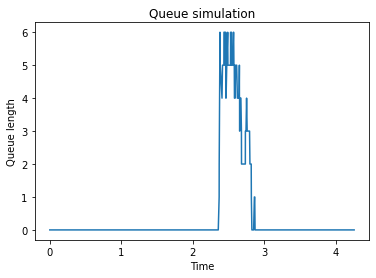

In [12]:
fig = plt.figure()
ax = plt.subplot(1,1,1)

ax.plot(times, queues)
ax.set(title='Queue simulation',
       xlabel='Time',
       ylabel='Queue length')
plt.show()

YS Video Plot - Calculate dt

sum of queues-331, sum of dqt-331.0


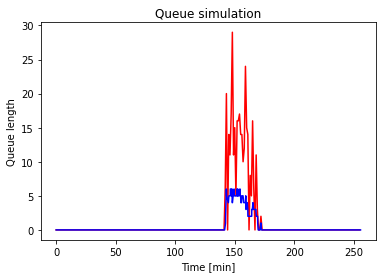

sum of gross_rev-21539.01991634599, sum of revenuedt-21539.019916345987
sum of expenses-5905.750797160863, sum of expensesdt-5936.700000000018


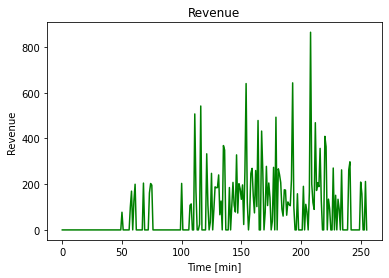

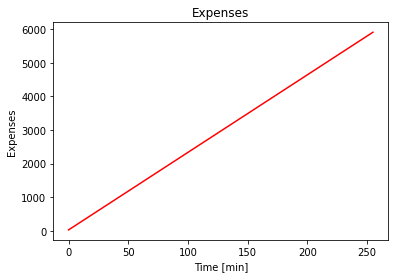

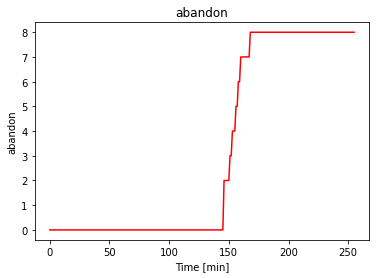

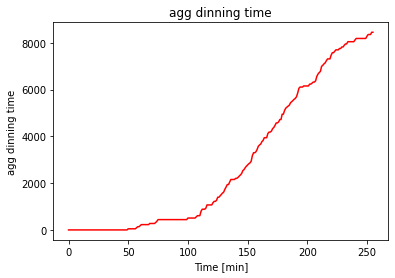

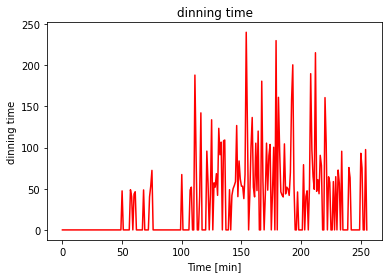

C:\Users\TSMAR\AppData\Local\Temp\ipykernel_16588\1350552156.py:100: RuntimeWarning: invalid value encountered in true_divide
  avgdinningtimedt = (np.array(dinningtimedt[1:])/np.array(dinningtimecountdt[1:]))


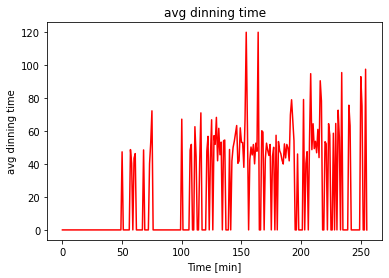

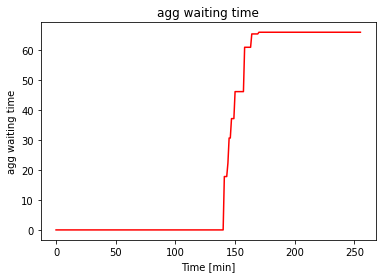

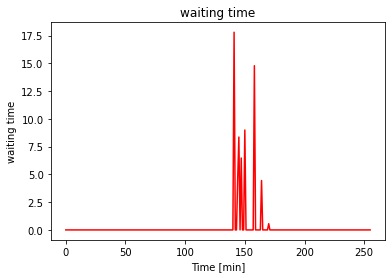

C:\Users\TSMAR\AppData\Local\Temp\ipykernel_16588\1350552156.py:134: RuntimeWarning: invalid value encountered in true_divide
  avgwaitingtimedt = (np.array(waitingtimedt[1:])/np.array(waitingtimecountdt[1:]))


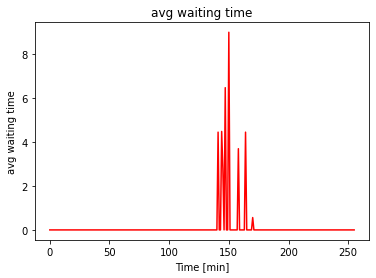

In [13]:
qdt = []
ddt = []
tf_min = round(60*max(times))
ddt = range(tf_min)
qdt = np.zeros(tf_min)

for dt in range(tf_min):
    for j in range(len(times)):
        if dt<=round(60*times[j]) and round(60*(times[j]))<dt+1:
            qdt[dt] = qdt[dt] + (queues[j])
    #print(f'time = {dt}, queue = {qdt[dt]}')

# Verify Calculation
print(f'sum of queues-{sum(queues)}, sum of dqt-{sum(qdt)}')
fig = plt.figure()
ax = plt.subplot(1,1,1)

timesdt = np.array(times)*60
ax.plot(ddt, qdt,color='red')
ax.plot(timesdt, queues,color='blue')
ax.set(title='Queue simulation',
       xlabel='Time [min]',
       ylabel='Queue length')
plt.show()

# revenue and expenses calculation dt
revenuedt = np.zeros(tf_min+1)
for dt in range(tf_min+1):
    for x in customers:
        if dt<=(60*x.departure_time) and (60*x.departure_time)<dt+1:
            if (x.revenue > 0):
                revenuedt[dt] = revenuedt[dt] + (x.revenue)
expensesdt = np.zeros(tf_min+1)
for dt in range(tf_min+1):
    expensesdt[dt] = 0.1*sum(np.array(list(scenario.table_arrangement.items()))[:,0]*np.array(list(scenario.table_arrangement.items()))[:,1])

print(f'sum of gross_rev-{gross_rev}, sum of revenuedt-{sum(revenuedt)}')
print(f'sum of expenses-{expenses}, sum of expensesdt-{sum(expensesdt)}')
fig = plt.figure()
ax = plt.subplot(1,1,1)

ax.plot(ddt, revenuedt[1:],color='green')
ax.set(title='Revenue',
       xlabel='Time [min]',
       ylabel='Revenue')
plt.show()

fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.plot(ddt, np.cumsum(expensesdt[1:]),color='red')
ax.set(title='Expenses',
       xlabel='Time [min]',
       ylabel='Expenses')
plt.show()

# abandon calculation dt
abandondt = np.zeros(tf_min+1)
for dt in range(tf_min+1):
    for x in customers:
        if dt<=(60*x.time_arrival+5) and (60*x.time_arrival+5)<dt+1:
            if (x.left > 0):
                abandondt[dt] = abandondt[dt] + 1
fig = plt.figure()
ax = plt.subplot(1,1,1)

ax.plot(ddt, np.cumsum(abandondt[1:]),color='red')
ax.set(title='abandon',
       xlabel='Time [min]',
       ylabel='abandon')
plt.show()

# dinning time 
dinningtimecountdt = np.zeros(tf_min+1)
dinningtimedt = np.zeros(tf_min+1)
for dt in range(tf_min+1):
    for x in customers:
        if dt<=(60*x.departure_time) and (60*x.departure_time)<dt+1:
            if (x.revenue > 0):
                dinningtimecountdt[dt] = dinningtimecountdt[dt] + 1
                dinningtimedt[dt] = dinningtimedt[dt] + 60*(x.departure_time-x.seated_time)

fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.plot(ddt, np.cumsum(dinningtimedt[1:]),color='red')
ax.set(title='agg dinning time',
       xlabel='Time [min]',
       ylabel='agg dinning time')
plt.show()

fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.plot(ddt, (dinningtimedt[1:]),color='red')
ax.set(title='dinning time',
       xlabel='Time [min]',
       ylabel='dinning time')
plt.show()

fig = plt.figure()
ax = plt.subplot(1,1,1)
avgdinningtimedt = (np.array(dinningtimedt[1:])/np.array(dinningtimecountdt[1:]))
avgdinningtimedt = np.nan_to_num(avgdinningtimedt)
ax.plot(ddt, avgdinningtimedt ,color='red')
ax.set(title='avg dinning time',
       xlabel='Time [min]',
       ylabel='avg dinning time')
plt.show()
 
# waiting time calculation dt
waitingtimecountdt = np.zeros(tf_min+1)
waitingtimedt = np.zeros(tf_min+1)
for dt in range(tf_min+1):
    for x in customers:
        if dt<=(60*x.time_arrival) and (60*x.time_arrival)<dt+1:
            if (x.seated_time >= x.time_arrival):
                waitingtimecountdt[dt] = waitingtimecountdt[dt] + 1
                waitingtimedt[dt] = waitingtimedt[dt] + 60*(x.seated_time-x.time_arrival)

fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.plot(ddt, np.cumsum(waitingtimedt[1:]),color='red')
ax.set(title='agg waiting time',
       xlabel='Time [min]',
       ylabel='agg waiting time')
plt.show()
fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.plot(ddt, (waitingtimedt[1:]),color='red')
ax.set(title='waiting time',
       xlabel='Time [min]',
       ylabel='waiting time')
plt.show()
fig = plt.figure()
ax = plt.subplot(1,1,1)
avgwaitingtimedt = (np.array(waitingtimedt[1:])/np.array(waitingtimecountdt[1:]))
avgwaitingtimedt = np.nan_to_num(avgwaitingtimedt)
ax.plot(ddt, avgwaitingtimedt ,color='red')
ax.set(title='avg waiting time',
       xlabel='Time [min]',
       ylabel='avg waiting time')
plt.show()

YS Arrange Table Location + Avaiability

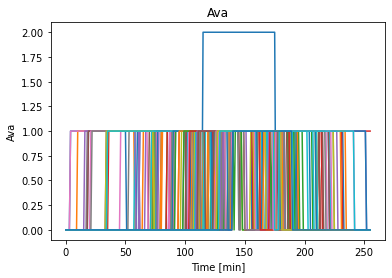

In [14]:
# YS

class TablesLocation:
    def __init__(self,id,size,x0,y0,tf_min):
        self.id = id
        self.size = size
        self.x0 = x0
        self.y0 = y0
        self.Avadt = np.zeros(tf_min)

    def avadtupdate(self,index,ta,td):
        self.Avadt[ta:td] = index
        

tables_arrangement = scenario.table_arrangement
table_size = [30,50,70,90]
tables_size = {
            2:table_size[0],
            3:table_size[1],
            4:table_size[2],
            5:table_size[3]
        }
tablesLoc = []
id = 0
x0 = 0
y0 = 0
dxy = 300
area = 3000
for table_size in tables_arrangement:
    for i in range(tables_arrangement[table_size]):
        tableLoc = TablesLocation(id,tables_size[table_size],x0,y0,tf_min) 
        tablesLoc.append(tableLoc)
        id += 1
        #x0 += 3*tables_size[table_size]
        x0 += dxy
        if x0>0.9*area:
            x0 = 0
            y0 +=dxy

# YS Check Table empty or taken
for cc in customers:
    tabi = cc.table
    if tabi>=0:
        ta = round(60*cc.seated_time)
        td = round(60*cc.departure_time)
        #print(f'ID:{tabi}, ta:{ta}, td:{td}')
        for tt in tablesLoc:
            if tt.id == tabi:
                #TablesLocation.avadtupdate(tt,1,ta,td)
                if cc.shared:
                    TablesLocation.avadtupdate(tt,2,ta,td)
                else:
                    TablesLocation.avadtupdate(tt,1,ta,td)

# verify
fig = plt.figure()
ax = plt.subplot(1,1,1)
for tt in tablesLoc:
#                print(tt.Avadt)
    ax.plot(ddt, tt.Avadt)
    ax.set(title='Ava',
        xlabel='Time [min]',
        ylabel='Ava')
plt.show()



YS Video Plot - Tables

In [15]:
# YS - Plot Table
tf = tf_min
dz = 5
dt = range(0, tf, dz)

Rdt5 = [sum(revenuedt[i:i+dz]) for i in range(0, len(revenuedt), dz)]
Edt5 = [sum(expensesdt[i:i+dz]) for i in range(0, len(expensesdt), dz)]
Qdt5 = [sum(qdt[i:i+dz]) for i in range(0, len(qdt), dz)]

Incomes = np.cumsum(revenuedt)
Expenses = np.cumsum(expensesdt)
Queues = np.cumsum(qdt)
Abandon = np.cumsum(abandondt)

Dinningt = np.cumsum(dinningtimedt)/np.cumsum(dinningtimecountdt)
Dinningt = np.nan_to_num(Dinningt)
Waitingt = np.cumsum(waitingtimedt)/np.cumsum(dinningtimecountdt)
Waitingt = np.nan_to_num(Waitingt)

C:\Users\TSMAR\AppData\Local\Temp\ipykernel_16588\2226753949.py:15: RuntimeWarning: invalid value encountered in true_divide
  Dinningt = np.cumsum(dinningtimedt)/np.cumsum(dinningtimecountdt)
C:\Users\TSMAR\AppData\Local\Temp\ipykernel_16588\2226753949.py:17: RuntimeWarning: invalid value encountered in true_divide
  Waitingt = np.cumsum(waitingtimedt)/np.cumsum(dinningtimecountdt)


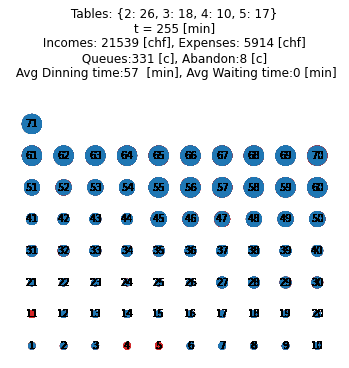

In [16]:
# YS - Plot Table
'''
tf = 30 # tf_min
dt = range(0, tf, 5)
Incomes = np.cumsum(revenuedt)
Expenses = np.cumsum(expensesdt)
Queues = np.cumsum(qdt)
Abandon = range(tf+1)
'''
fig, ax = plt.subplots(figsize = (6,6),facecolor=(1, 1, 1))
title = fig.text(0.5,1.1, "", fontsize=12,transform=ax.transAxes, ha="center")

def animate(i):
    # sum(c[i:i+5]) for i in range(0, len(c), 5)

    title.set_text(f' Tables: {tables_arrangement} \n t = {dt[i]} [min] \n Incomes: {round(Incomes[dt[i]])} [chf], Expenses: {round(Expenses[dt[i]])} [chf] \n Queues:{round(Queues[dt[i]])} [c], Abandon:{round(Abandon[dt[i]])} [c] \n Avg Dinning time:{round(Dinningt[dt[i]])}  [min], Avg Waiting time:{round(Waitingt[dt[i]])} [min]')
    for tableLoc in tablesLoc:
        if i>0:
            if np.max(tableLoc.Avadt[dt[i-1]:dt[i]]) == 1:
                circle = plt.Circle((tableLoc.x0, tableLoc.y0), radius=tableLoc.size, color='tab:red') # Lighter
            if np.max(tableLoc.Avadt[dt[i-1]:dt[i]]) == 2:
                circle = plt.Circle((tableLoc.x0, tableLoc.y0), radius=tableLoc.size, color='tab:green') # Lighter
            if np.max(tableLoc.Avadt[dt[i-1]:dt[i]]) == 0:
                circle = plt.Circle((tableLoc.x0, tableLoc.y0), radius=tableLoc.size, color='tab:blue') # Lighter
        else:
            circle = plt.Circle((tableLoc.x0, tableLoc.y0), radius=tableLoc.size, color='tab:blue') # Lighter
        ax.add_patch(circle)
        label = ax.annotate(f"{tableLoc.id+1}", xy=(tableLoc.x0, tableLoc.y0), ha="center", va="center")#, fontsize=10)
    ax.axis('scaled')
    ax.axis('off')
    
    return circle

anim = animation.FuncAnimation(fig, animate, frames=(len(dt)), interval=(len(dt)))#  , init_func=init,repeat=True,blit = False, frames=tf


f_name = r'./Output/ROSS_Output_'
f_time = datetime.now().strftime("%Y-%m-%d_%I-%M-%S_%p")
f_type = '.gif'
f = f_name + f_time + f_type

#f= r"./Output/ROSS_Output_V3.gif"
writergif = animation.PillowWriter(fps=1)
anim.save(f, writer=writergif)

Extra

In [17]:
tab = []
for j in range(len(customers)):
    tab.append(customers[j].departure_time-customers[j].seated_time)